# Production Model

Here we are trying to train a model and export it for inference purpose.
We can use that model in a production enviroment. (via CPU)


In [1]:
from fastai2.vision.all import *
from fastai2.vision.widgets import *
from utils import *

## Configure the Data Path

Change the following section as needed based your setup.

In [2]:
data_path = Path('../data')
synth_images_path = data_path/"synths"

## Bing Image Search

For this we are going to use Bing Image Search.
Which has a good FREE tier.

In [3]:
bing_image_search_key="06b8097bcdaa46b3b65312dbae563891"

In [4]:
result = search_images_bing(bing_image_search_key, 'Digitakt')

In [5]:
urls = result.attrgot('content_url')
dest = "/tmp/digitakt1.jpg"
download_url(urls[0], dest)

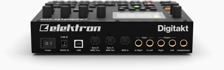

In [6]:
img = Image.open(dest)
img.to_thumb(224, 224)

## Download Images to Train

Here we are downloading some images for three types of synths I love.

In [7]:
synth_types = 'Digitakt', 'teenage engineering opz', 'Moog Grandmother'

In [8]:
if not synth_images_path.exists():
    synth_images_path.mkdir()
    for synth_type in synth_types:
        dest = (synth_images_path/synth_type)
        dest.mkdir(exist_ok=True)
        image_result = search_images_bing(bing_image_search_key, synth_type)
        download_images(dest, urls=image_result.attrgot('content_url'))

In [9]:
image_paths = get_image_files(synth_images_path)
image_paths

(#427) [Path('../data/synths/teenage engineering opz/00000062.jpg'),Path('../data/synths/teenage engineering opz/00000009.jpg'),Path('../data/synths/teenage engineering opz/00000130.jpg'),Path('../data/synths/teenage engineering opz/00000021.jpg'),Path('../data/synths/teenage engineering opz/00000090.jpg'),Path('../data/synths/teenage engineering opz/00000074.jpg'),Path('../data/synths/teenage engineering opz/00000028.jpg'),Path('../data/synths/teenage engineering opz/00000026.jpg'),Path('../data/synths/teenage engineering opz/00000056.jpg'),Path('../data/synths/teenage engineering opz/00000069.jpg')...]

In [10]:
## We need to find out failed downloads and clean them.
## So, they don't affect our model
failed_downloads = verify_images(image_paths)
failed_downloads

(#0) []

In [11]:
failed_downloads.map(Path.unlink)

(#0) []

## Create Data Loaders from the Images

To train our model, we need to convert our images into the data loaders. For that, we use the `DataBlock` API.

In [78]:
synths_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)
)

In [79]:
synths_dls = synths_db.dataloaders(synth_images_path)

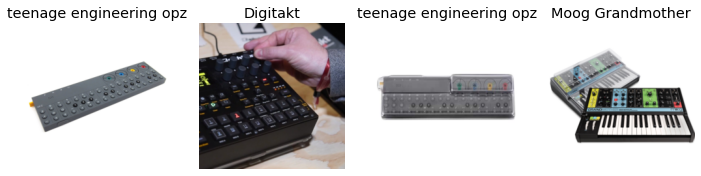

In [64]:
synths_dls.train.show_batch(max_n=4, nrows=1)

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


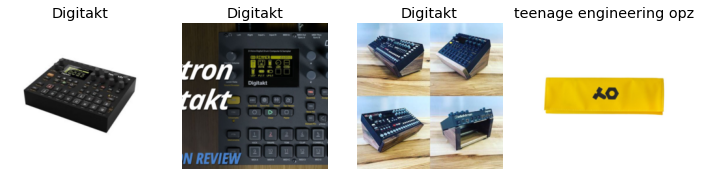

In [65]:
synths_dls.valid.show_batch(max_n=4, nrows=1)

## Let's Starting Learning

In [82]:
learn = cnn_learner(synths_dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.502342,0.604698,0.263158,00:05


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.429974,0.212982,0.118421,00:06
1,0.320235,0.083894,0.052632,00:06
2,0.232561,0.067016,0.039474,00:06
3,0.187373,0.049082,0.026316,00:05
4,0.149023,0.050708,0.026316,00:06


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/I

## Visualize the Result

We need to see how our model performed. Let's have a look

In [83]:
interp = ClassificationInterpretation.from_learner(learn)

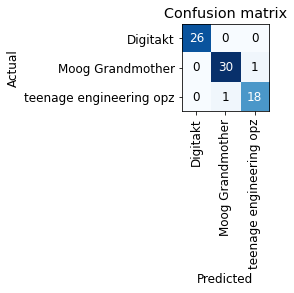

In [84]:
interp.plot_confusion_matrix()

All looks fine. Let's check these worst cases. May be they are wrong images may be.

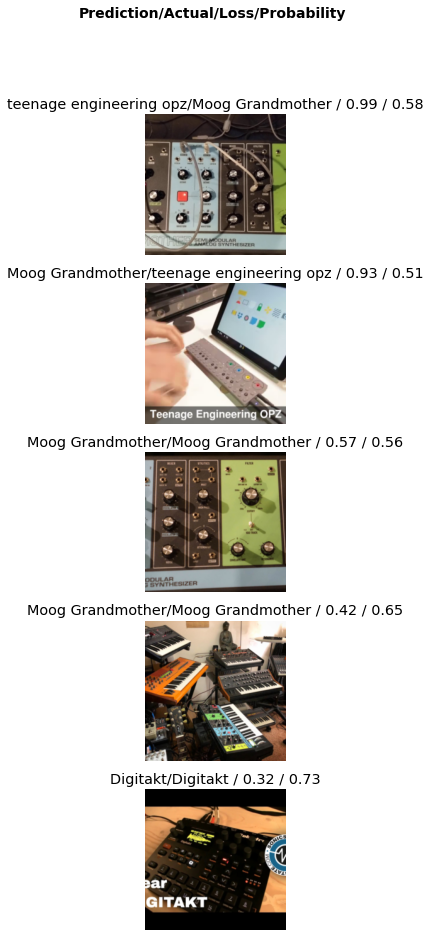

In [85]:
interp.plot_top_losses(5, nrows=5)

As you can see, those are pretty strange images. It's really impressive that they can see identify some of those correctly.

## Cleaning Data

Here we need to check for predictions high loss and remove those.
So, we have a much better dataset.

In [75]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [77]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), synth_images_path/cat)

**Data cleaning is very important**

These images contains data which are not 100% accurate. So, by training and cleaning multiple times, we can get a good model because our images are good.

In this case, I managed get it down from 8% error rate to 2% error rate.

Currently, we don't have bad images but we have very little data.
That's why model is not keep improving. <br/>
(Sometimes it created models with error rate is ~6%)

## Data Augmentation

With this, we are going to generate multiple images for the same data set by making various changes to the same image. 
By doing that, we can simply increase the set of images we expose to the model.

In [111]:
synths_db = synths_db.new(item_tfms=Resize(224), batch_tfms=aug_transforms(mult=1))

In [112]:
synths_dls = synths_db.dataloaders(synth_images_path)

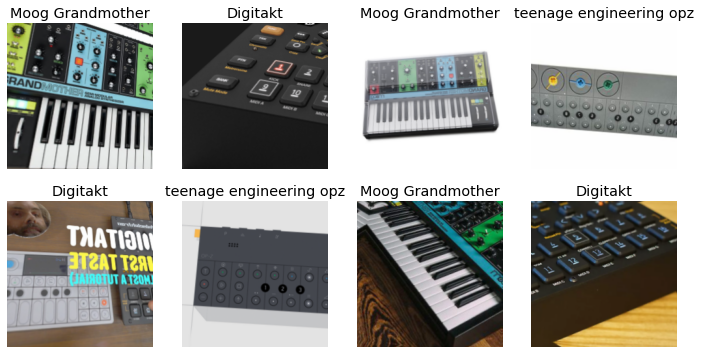

In [113]:
synths_dls.train.show_batch(max_n=8, nrows=2)

In [114]:
learn = cnn_learner(synths_dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.794032,0.657008,0.289474,00:06


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.698707,0.325132,0.118421,00:06
1,0.517802,0.188103,0.052632,00:05
2,0.398478,0.165770,0.052632,00:06
3,0.324853,0.150647,0.065789,00:06


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [106]:
interp = ClassificationInterpretation.from_learner(learn)

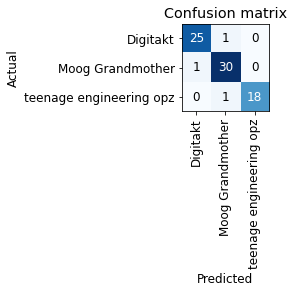

In [115]:
interp.plot_confusion_matrix()

**But it seems like still it's not improving.**

May be that's because of our dataset is still small.
We can find answers later on.

## Randomize Crop (just like Data Augmentation)

But here we crop the image for multiple parts. Let's see how it works.

In [119]:
synths_db = synths_db.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))

In [120]:
synths_dls = synths_db.dataloaders(synth_images_path)

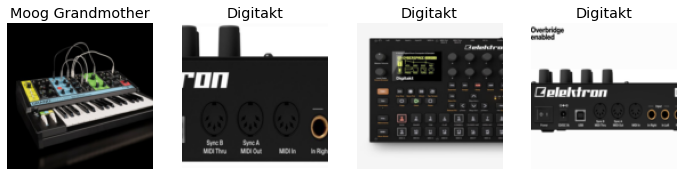

In [126]:
synths_dls.train.show_batch(max_n=4, nrows=1)

In [130]:
learn = cnn_learner(synths_dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.803825,0.649057,0.236842,00:05


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.894521,0.291835,0.092105,00:05
1,0.723015,0.147036,0.039474,00:05
2,0.573689,0.127972,0.039474,00:06
3,0.479186,0.129941,0.039474,00:05


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## Conclusion

Even if we do a lot of tricks, the model is not improving a lot.
The reason could be that our images are limited anyway.
Or this is the best it can do.

But I hope to learn a bit more about this in later classes.

## Export the Model

In [20]:
learn.export("synths.pkl")

In [21]:
cwd = Path()
cwd.ls()

(#9) [Path('.gitignore'),Path('synths.pkl'),Path('utils.py'),Path('.git'),Path('01-intro.ipynb'),Path('.ipynb_checkpoints'),Path('02-production.ipynb'),Path('push.sh'),Path('__pycache__')]

## Inferencing

Inferencing is the way to predict based on the model we generated. Usually we do this via the CPU.
It's not useufl to do this inside a GPU.

In [22]:
learn_inf = load_learner("synths.pkl")

In [23]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [24]:
uploaded_image = PILImage.create(uploader.data[0])
uploaded_image

IndexError: list index out of range

In [ ]:
learn_inf.predict(uploaded_image)